### Loading Subscription Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the subscriptions dataset
df_subs = pd.read_csv('subscriptions.csv')

# Convert dates to datetime
df_subs['start_date'] = pd.to_datetime(df_subs['start_date'])
df_subs['churn_date'] = pd.to_datetime(df_subs['churn_date'])

# Define our analysis timeframe (from the first signup to the last possible event)
start_period = df_subs['start_date'].min().to_period('M')
end_period = df_subs['start_date'].max().to_period('M')
range_of_months = pd.period_range(start_period, end_period, freq='M')

print(f"Analyzing subscription health from {start_period} to {end_period}")

Analyzing subscription health from 2024-01 to 2024-06


### Calculating Monthly MRR

In [2]:
mrr_list = []

for month in range_of_months:
    month_start = month.to_timestamp()
    month_end = month.to_timestamp(how='E')
    
    # A user is active in this month if:
    # 1. They started on or before the end of this month
    # 2. They either haven't churned, or churned AFTER the start of this month
    active_subs = df_subs[
        (df_subs['start_date'] <= month_end) & 
        ((df_subs['churn_date'].isna()) | (df_subs['churn_date'] > month_start))
    ]
    
    monthly_mrr = active_subs['monthly_revenue'].sum()
    mrr_list.append({'month': month, 'mrr': monthly_mrr, 'active_users': len(active_subs)})

df_mrr = pd.DataFrame(mrr_list)
df_mrr['month'] = df_mrr['month'].astype(str)
df_mrr.head()

,month,mrr,active_users
0,2024-01,994.50,116
1,2024-02,2033.91,235
2,2024-03,2815.95,324
3,2024-04,3595.44,411
4,2024-05,4409.97,504


### Calculating Monthly Churn Rate

In [3]:
churn_list = []

for i in range(1, len(range_of_months)):
    prev_month = range_of_months[i-1].to_timestamp(how='E')
    curr_month_start = range_of_months[i].to_timestamp()
    curr_month_end = range_of_months[i].to_timestamp(how='E')
    
    # Customers at the start of the month (Active at the end of last month)
    start_count = len(df_subs[
        (df_subs['start_date'] <= prev_month) & 
        ((df_subs['churn_date'].isna()) | (df_subs['churn_date'] > prev_month))
    ])
    
    # Customers who churned DURING this month
    churned_count = len(df_subs[
        (df_subs['churn_date'] >= curr_month_start) & 
        (df_subs['churn_date'] <= curr_month_end)
    ])
    
    churn_rate = (churned_count / start_count) if start_count > 0 else 0
    churn_list.append({'month': str(range_of_months[i]), 'churn_rate': churn_rate})

df_churn = pd.DataFrame(churn_list)

In [4]:
df_churn.head(5)

,month,churn_rate
0,2024-02,0.198276
1,2024-03,0.103286
2,2024-04,0.062500
3,2024-05,0.045685
4,2024-06,0.041152


### Calculating ARPU and LTV

In [8]:
# 1. Average Revenue Per User (ARPU)
avg_arpu = df_subs['monthly_revenue'].mean()

# 2. Average Monthly Churn Rate
avg_churn = df_churn['churn_rate'].mean()

# 3. Customer Lifetime Value (LTV) Formula: ARPU / Churn Rate
ltv = avg_arpu / avg_churn

print(f"- Key Subscription Metrics -")
print(f"Average Monthly ARPU: ${avg_arpu:.2f}")
print(f"Average Monthly Churn: {avg_churn*100:.2f}%")
print(f"Estimated LTV: ${ltv:.2f}")

- Key Subscription Metrics -
Average Monthly ARPU: $8.76
Average Monthly Churn: 9.02%
Estimated LTV: $97.12


### Visualizing Business Health

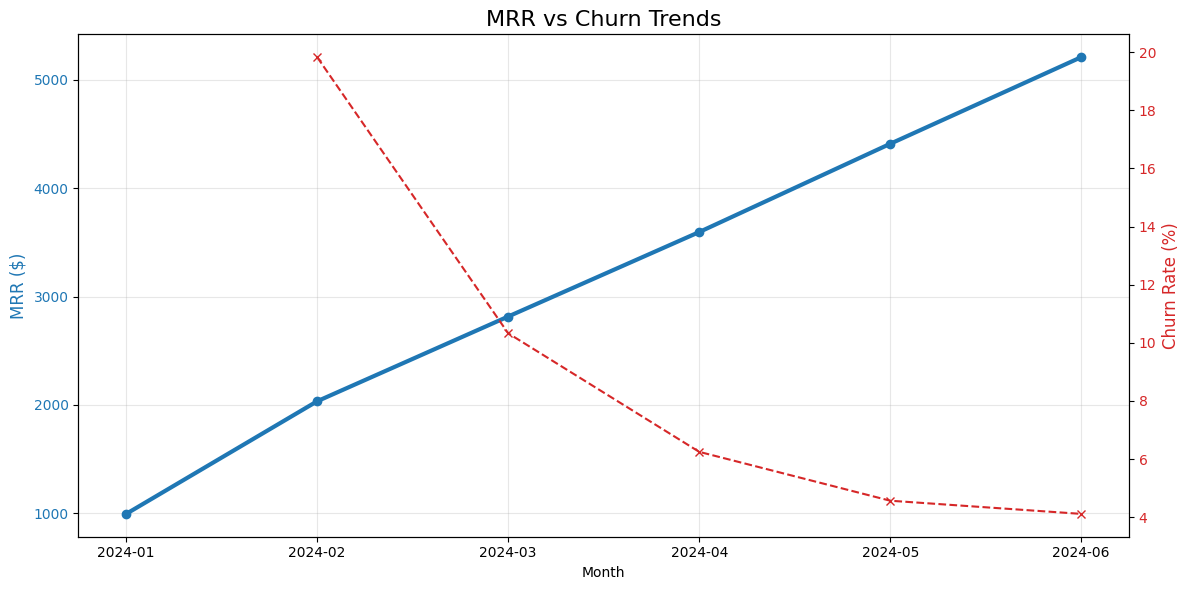

In [7]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot MRR
ax1.set_xlabel('Month')
ax1.set_ylabel('MRR ($)', color='tab:blue', fontsize=12)
ax1.plot(df_mrr['month'], df_mrr['mrr'], color='tab:blue', marker='o', linewidth=3, label='MRR')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(alpha=0.3)

# Create a second axis for Churn Rate
ax2 = ax1.twinx()
ax2.set_ylabel('Churn Rate (%)', color='tab:red', fontsize=12)
ax2.plot(df_churn['month'], df_churn['churn_rate'] * 100, color='tab:red', linestyle='--', marker='x', label='Churn Rate')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('MRR vs Churn Trends', fontsize=16)
fig.tight_layout()
plt.show()

#### SubscriptionKPIs (MRR, Churn & LTV calculation)

**Period analyzed**: January 2024 – June 2024  
**Data sources**: `subscriptions.csv` (cleaned & aggregated monthly)

1. **Monthly Recurring Revenue (MRR) & Active Users**  
   Strong early-stage growth observed:

   | Month     | MRR       | Active Users | MoM Growth |
   |-----------|-----------|--------------|------------|
   | 2024-01   | $994.50   | 116          | —          |
   | 2024-02   | $2,033.91 | 235          | +104.5%    |
   | 2024-03   | $2,815.95 | 324          | +38.5%     |
   | 2024-04   | $3,595.44 | 411          | +27.7%     |
   | 2024-05   | $4,409.97 | 504          | +22.6%     |

   → MRR grew **~4.4×** in five months.

2. **Monthly Customer Churn Rate**  
   Impressive improvement in retention:

   | Month     | Churn Rate |
   |-----------|------------|
   | 2024-02   | 19.83%     |
   | 2024-03   | 10.33%     |
   | 2024-04   | 6.25%      |
   | 2024-05   | 4.57%      |
   | 2024-06   | 4.12%      |

   → Churn dropped from ~20% → ~4% — strong signal of improving product-market fit.

3. **Core Business Metrics**

   - **Average Monthly ARPU**: **$8.76**  
   - **Average Monthly Churn**: **9.02%**  
   - **Estimated Customer LTV**: **$97.12**  
     (Simple method: LTV = ARPU ÷ Monthly Churn Rate)

4. **Visualizations Included**
   - MRR & active users growth trend (line + bar)
   - Churn rate decline over time

### Business Story & Takeaways

- Rapid revenue scaling in early 2024
- Significant churn reduction within months — likely from onboarding improvements, feature releases, or pricing optimization
- Healthy LTV benchmark (~$97) for evaluating customer acquisition cost (CAC) payback
- Classic healthy SaaS trajectory: accelerating revenue + improving retention
